# Analyzing Global Job Market Trends and Skill Demands Using Big Data
## A LinkedIn Jobs & Skills 2024 Study - Phase 2 (OPTIMIZED)

**Team Members:**
- Sahitya Gantala (sahityag@buffalo.edu)
- Shilpa Ghosh (shilpagh@buffalo.edu)
- Aditya Rajesh Sawant (asawant5@buffalo.edu)

**Dataset:** 1.3M LinkedIn Jobs and Skills (2024)

**Course:** CSE 587 - Data Intensive Computing, Fall 2025

**Optimizations:**
- Fixed PySpark memory errors
- Improved deduplication strategy
- Added error handling and recovery
- Memory-efficient data processing

## Section 1: Environment Setup and Spark Configuration

In [1]:
# # Install dependencies
# !apt-get install openjdk-11-jdk-headless -qq > /dev/null
# !pip install pyspark pandas matplotlib seaborn scikit-learn wordcloud kaggle -q

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# print("Dependencies installed successfully!")

In [2]:
try:
    spark.stop()
except:
    pass

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql import functions as F
from pyspark.sql.functions import (col, lower, trim, split, size, explode, count, avg, desc, asc,
    collect_list, array_distinct, concat_ws, regexp_replace, when, countDistinct, sum as spark_sum,
    dense_rank, row_number, broadcast, datediff, current_date, max as spark_max, lit, to_date)
from pyspark.sql.window import Window

from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, Normalizer, PCA
from pyspark.ml.clustering import KMeans, BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import time
import gc
import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler as SKStandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier as SKRandomForestClassifier
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.utils import resample

import nltk
from nltk.corpus import stopwords

import json
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


In [4]:
# Configure Spark Session
conf = SparkConf() \
    .setAppName('LinkedIn_Jobs_Analysis_Phase2_OPTIMIZED') \
    .setMaster('local[*]') \
    .set('spark.driver.memory', '12g') \
    .set('spark.driver.maxResultSize', '3g') \
    .set('spark.executor.memory', '4g') \
    .set('spark.sql.shuffle.partitions', '100') \
    .set('spark.default.parallelism', '100') \
    .set('spark.sql.execution.arrow.pyspark.enabled', 'true') \
    .set('spark.sql.adaptive.enabled', 'true') \
    .set('spark.sql.adaptive.coalescePartitions.enabled', 'true') \
    .set('spark.sql.adaptive.skewJoin.enabled', 'true') \
    .set('spark.memory.fraction', '0.8') \
    .set('spark.memory.storageFraction', '0.3')

spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel("ERROR")

print("="*70)
print("SPARK SESSION INITIALIZED")
print("="*70)
print(f"Spark Version: {spark.version}")
print(f"Driver Memory: {spark.sparkContext._conf.get('spark.driver.memory')}")
print(f"Shuffle Partitions: {spark.sparkContext._conf.get('spark.sql.shuffle.partitions')}")
print(f"Memory Fraction: {spark.sparkContext._conf.get('spark.memory.fraction')}")
print("="*70)

SPARK SESSION INITIALIZED
Spark Version: 4.0.1
Driver Memory: 12g
Shuffle Partitions: 100
Memory Fraction: 0.8


## Section 2: Kaggle Setup and Data Download (FIXED)

In [5]:

print("="*70)
print("KAGGLE CREDENTIALS CHECK")
print("="*70)

kaggle_dir = Path.home() / ".kaggle"
kaggle_json = kaggle_dir / "kaggle.json"

if not kaggle_json.exists():
    print("\nKaggle credentials not found!")
    print("\nPlease enter your Kaggle credentials:")
    print("(Get them from: https://www.kaggle.com/settings/account)\n")

    username = input("Kaggle Username: ").strip()
    key = input("Kaggle API Key: ").strip()

    if username and key:
        kaggle_dir.mkdir(exist_ok=True)
        with open(kaggle_json, 'w') as f:
            json.dump({"username": username, "key": key}, f, indent=2)

        os.chmod(kaggle_json, 0o600)
        print("\nCredentials saved!")
    else:
        print("\nInvalid credentials. Please run this cell again.")
else:
    print("Kaggle credentials found")

print("="*70)

KAGGLE CREDENTIALS CHECK
Kaggle credentials found


In [6]:
# import zipfile

# DATASET_PATH = "asaniczka/1-3m-linkedin-jobs-and-skills-2024"
EXTRACT_DIR = "./linkedin_dataset"
# ZIP_FILE = "1-3m-linkedin-jobs-and-skills-2024.zip"

# print("="*70)
# print("DATA DOWNLOAD AND EXTRACTION")
# print("="*70)

# if os.path.exists(EXTRACT_DIR) and os.listdir(EXTRACT_DIR):
#     print("\nDataset already exists!")
#     print(f"Location: {EXTRACT_DIR}")
#     !ls -lh {EXTRACT_DIR}
# else:
#     print("\nDownloading dataset...")
#     print("(This may take several minutes)")
#     start = time.time()

#     try:
#         result = !kaggle datasets download -d {DATASET_PATH} 2>&1

#         if not os.path.exists(ZIP_FILE):
#             print("\nDownload failed!")
#             print("\nTroubleshooting steps:")
#             print("1. Visit: https://www.kaggle.com/datasets/asaniczka/1-3m-linkedin-jobs-and-skills-2024")
#             print("2. Click 'Download' to accept terms")
#             print("3. Re-run this cell")
#             raise Exception("Dataset download failed")

#         print(f"\nDownloaded in {time.time()-start:.1f}s")

#         print("\nExtracting files...")
#         start = time.time()

#         os.makedirs(EXTRACT_DIR, exist_ok=True)
#         with zipfile.ZipFile(ZIP_FILE, 'r') as zip_ref:
#             files = zip_ref.namelist()
#             print(f"   Found {len(files)} files")
#             zip_ref.extractall(EXTRACT_DIR)

#         print(f"Extracted in {time.time()-start:.1f}s")

#         os.remove(ZIP_FILE)
#         print("Cleaned up zip file")

#     except Exception as e:
#         print(f"\nError: {e}")
#         raise

# print("\nDataset files:")
# !ls -lh {EXTRACT_DIR}
# print("\n" + "="*70)

## Section 3: Data Loading and Cleaning (OPTIMIZED)

In [7]:
# Section 3: Data Loading (CORRECTED FOR ACTUAL FILES)

print("="*70)
print("DATA LOADING")
print("="*70)

# File 1: Job Postings (396 MB)
print("\nLoading job postings...")
start = time.time()

df_postings = spark.read.csv(
    f"{EXTRACT_DIR}/linkedin_job_postings.csv",
    header=True,
    inferSchema=False,
    multiLine=True,
    escape='"'
).repartition(100)

initial_count = df_postings.count()
print(f"Loaded in {time.time()-start:.1f}s")
print(f"Records: {initial_count:,}")
print(f"Columns: {len(df_postings.columns)}")

# File 2: Job Skills (641 MB)
print("\nLoading skills data...")
start = time.time()

df_skills = spark.read.csv(
    f"{EXTRACT_DIR}/job_skills.csv",
    header=True,
    inferSchema=False
).repartition(100)

skills_count = df_skills.count()
print(f"Loaded in {time.time()-start:.1f}s")
print(f"Records: {skills_count:,}")

# File 3: Job Summary (4.8 GB - VERY LARGE!)
print("\nLoading job summary...")
print("WARNING: Large file (4.8 GB) - this may take 2-3 minutes")
start = time.time()

df_summary = spark.read.csv(
    f"{EXTRACT_DIR}/job_summary.csv",
    header=True,
    inferSchema=False,
    multiLine=True,
    escape='"'
).repartition(200)  # More partitions for large file

summary_count = df_summary.count()
print(f"Loaded in {time.time()-start:.1f}s")
print(f"Records: {summary_count:,}")
print(f"Columns: {len(df_summary.columns)}")

print("\n" + "="*70)
print("ALL DATA LOADED SUCCESSFULLY")
print("="*70)
print(f"\nDataset Summary:")
print(f"• Job Postings: {initial_count:,} records")
print(f"• Skills: {skills_count:,} records")
print(f"• Summary: {summary_count:,} records")
print("="*70)

DATA LOADING

Loading job postings...
Loaded in 4.7s
Records: 1,348,454
Columns: 14

Loading skills data...
Loaded in 4.0s
Records: 1,296,381

Loading job summary...
Loaded in 20.1s
Records: 1,297,332
Columns: 2

ALL DATA LOADED SUCCESSFULLY

Dataset Summary:
• Job Postings: 1,348,454 records
• Skills: 1,296,381 records
• Summary: 1,297,332 records


## Section 3 part 2 Deduplication
Cleaned and deduplicated only df_postings to create the new DataFrame df_postings_clean.

- **Selects Target Data**: It works exclusively with the df_postings DataFrame.

- **Deduplication**: It uses the Spark function .dropDuplicates(['job_link']) to remove any rows that have the same value in the job_link column. This ensures each job posting is unique.

- **Create New DataFrame**: The resulting clean data is saved into a new DataFrame called df_postings_clean.

- **Optimization**: It uses Spark methods like .repartition() and .coalesce() to optimize how the deduplication process is handled across the cluster, which is a key part of the "memory-efficient" approach.

- **Caching**: It caches df_postings_clean.cache() to speed up future operations that use this cleaned table.

In [8]:
# Deduplication
print("="*70)
print("DATA DEDUPLICATION")
print("="*70)

print("\nRemoving duplicate job postings...")
start = time.time()

try:
    df_postings_clean = df_postings.dropDuplicates(['job_link']) \
        .repartition(100)

    df_postings_clean.cache()

    final_count = df_postings_clean.count()
    duplicates_removed = initial_count - final_count

    print(f"\nDeduplication complete in {time.time()-start:.1f}s")
    print(f"Initial records: {initial_count:,}")
    print(f"Final records: {final_count:,}")
    print(f"Duplicates removed: {duplicates_removed:,}")
    print(f"Retention rate: {final_count/initial_count*100:.1f}%")

except Exception as e:
    print(f"\nStandard deduplication failed: {e}")
    print("\nTrying alternative method with sampling...")

    sample_fraction = 0.1
    df_sample = df_postings.sample(False, sample_fraction, seed=42)

    sample_initial = df_sample.count()
    sample_clean = df_sample.dropDuplicates(['job_link']).count()
    dup_ratio = (sample_initial - sample_clean) / sample_initial

    print(f"\nSample analysis (10%):")
    print(f"Sample duplicates: {dup_ratio*100:.1f}%")
    print(f"Estimated full duplicates: {int(initial_count * dup_ratio):,}")

    df_postings_clean = df_postings \
        .repartition(200, 'job_link') \
        .dropDuplicates(['job_link']) \
        .coalesce(100)

    df_postings_clean.cache()
    final_count = df_postings_clean.count()

    print(f"\nAlternative deduplication successful")
    print(f"Final records: {final_count:,}")

print("\n" + "="*70)

DATA DEDUPLICATION

Removing duplicate job postings...

Deduplication complete in 13.1s
Initial records: 1,348,454
Final records: 1,348,454
Duplicates removed: 0
Retention rate: 100.0%



## Section 3 Part 3: Data Quality Checks

In [9]:
# Basic data quality checks
print("="*70)
print("DATA QUALITY CHECKS")
print("="*70)

print("\nSchema:")
df_postings_clean.printSchema()

print("\nMissing values:")
null_counts = df_postings_clean.select(
    [count(when(col(c).isNull(), c)).alias(c) for c in df_postings_clean.columns]
).toPandas()

null_pct = (null_counts / final_count * 100).T
null_pct.columns = ['Missing %']
print(null_pct[null_pct['Missing %'] > 0].sort_values('Missing %', ascending=False).head(10))

print("\nData quality check complete")
print("="*70)

DATA QUALITY CHECKS

Schema:
root
 |-- job_link: string (nullable = true)
 |-- last_processed_time: string (nullable = true)
 |-- got_summary: string (nullable = true)
 |-- got_ner: string (nullable = true)
 |-- is_being_worked: string (nullable = true)
 |-- job_title: string (nullable = true)
 |-- company: string (nullable = true)
 |-- job_location: string (nullable = true)
 |-- first_seen: string (nullable = true)
 |-- search_city: string (nullable = true)
 |-- search_country: string (nullable = true)
 |-- search_position: string (nullable = true)
 |-- job_level: string (nullable = true)
 |-- job_type: string (nullable = true)


Missing values:
              Missing %
job_location   0.001409
company        0.000816

Data quality check complete


## Section 4: Data Preprocessing
Selected, cleaned, and filtered columns from only df_postings_clean to create the final working table df_work.

In [10]:
# Data Preprocessing
print("="*70)
print("DATA PREPROCESSING")
print("="*70)

print("\nCreating working dataset...")

df_work = df_postings_clean.select(
    'job_link',
    trim(lower(col('job_title'))).alias('job_title'),
    col('company').alias('company_name'),
    col('job_location').alias('location'),
    'job_level',
    col('job_type').alias('employment_type'),
    'search_city',
    'search_country',
    'search_position',
    'first_seen'
)

df_work = df_work.filter(
    col('job_title').isNotNull() &
    col('job_link').isNotNull()
)

df_work.cache()
work_count = df_work.count()

print(f"Working dataset ready")
print(f"Records: {work_count:,}")
print(f"Columns: {len(df_work.columns)}")

print("\nSample data:")
df_work.show(5, truncate=50)

print("\nDataset Overview:")

print("\nTop 10 Countries:")
df_work.groupBy('search_country').count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .show(truncate=False)

print("\nTop 10 Cities:")
df_work.groupBy('search_city').count() \
    .orderBy(desc('count')) \
    .limit(10) \
    .show(truncate=False)

print("\nEmployment Types:")
df_work.groupBy('employment_type').count() \
    .orderBy(desc('count')) \
    .show(truncate=False)

print("\nJob Levels:")
df_work.groupBy('job_level').count() \
    .orderBy(desc('count')) \
    .show(truncate=False)

print("\n" + "="*70)
print("PREPROCESSING COMPLETE")
print("="*70)

DATA PREPROCESSING

Creating working dataset...
Working dataset ready
Records: 1,348,454
Columns: 10

Sample data:
+--------------------------------------------------+-----------------------------------------+---------------------------+----------------------------------+----------+---------------+-----------+--------------+----------------------+----------+
|                                          job_link|                                job_title|               company_name|                          location| job_level|employment_type|search_city|search_country|       search_position|first_seen|
+--------------------------------------------------+-----------------------------------------+---------------------------+----------------------------------+----------+---------------+-----------+--------------+----------------------+----------+
|https://uk.linkedin.com/jobs/view/occupational-...|              occupational health advisor|        OH Talent Solutions|Leicester, England, Unite

## Section 5: Joining with Skills Data

In [11]:
# Skills Join
print("="*70)
print("JOINING SKILLS DATA")
print("="*70)

print("\nPreparing skills data...")

df_skills_clean = df_skills.select(
    'job_link',
    trim(lower(col('job_skills'))).alias('skill')
).filter(col('skill').isNotNull())

print("\nAggregating skills per job...")
start = time.time()

df_skills_agg = df_skills_clean.groupBy('job_link').agg(
    collect_list('skill').alias('skills_list'),
    count('skill').alias('skill_count')
)

df_skills_agg.cache()
skills_agg_count = df_skills_agg.count()

print(f"Skills aggregated in {time.time()-start:.1f}s")
print(f"Unique jobs with skills: {skills_agg_count:,}")

print("\nJoining with job postings...")
start = time.time()

if skills_agg_count < 1000000:
    print("Using broadcast join")
    df_final = df_work.join(
        broadcast(df_skills_agg),
        on='job_link',
        how='left'
    )
else:
    print("Using standard join")
    df_final = df_work.join(
        df_skills_agg,
        on='job_link',
        how='left'
    )

df_final = df_final.fillna({'skill_count': 0})

df_final.cache()
final_count_with_skills = df_final.count()

print(f"\nJoin complete in {time.time()-start:.1f}s")
print(f"Final records: {final_count_with_skills:,}")

jobs_with_skills = df_final.filter(col('skill_count') > 0).count()
jobs_without_skills = final_count_with_skills - jobs_with_skills

print(f"\nSkill coverage:")
print(f"Jobs with skills: {jobs_with_skills:,} ({jobs_with_skills/final_count_with_skills*100:.1f}%)")
print(f"Jobs without skills: {jobs_without_skills:,} ({jobs_without_skills/final_count_with_skills*100:.1f}%)")

print("\nSample joined data:")
df_final.select('job_title', 'company_name', 'skill_count').show(5)

df_final.write.parquet("./df_final.parquet", mode="overwrite")

print("\n" + "="*70)

JOINING SKILLS DATA

Preparing skills data...

Aggregating skills per job...
Skills aggregated in 8.6s
Unique jobs with skills: 1,294,374

Joining with job postings...
Using standard join

Join complete in 5.3s
Final records: 1,348,454

Skill coverage:
Jobs with skills: 1,294,374 (96.0%)
Jobs without skills: 54,080 (4.0%)

Sample joined data:
+--------------------+--------------------+-----------+
|           job_title|        company_name|skill_count|
+--------------------+--------------------+-----------+
|warehouse supervi...|Global Projects S...|          1|
|expression of int...|    Queensland Hydro|          0|
|account executive...|          DuluxGroup|          1|
|account manager -...|    Impel Management|          1|
|accountant (inter...|New Point Recruit...|          1|
+--------------------+--------------------+-----------+
only showing top 5 rows



## Section 6: Exploratory Data Analysis

## Goal 1: Skills Analysis

SKILLS ANALYSIS

Converting to Pandas...
Loaded 1,348,454 records in 7.8s

Processing skills...
Text processed in 18.6s

Extracting and counting skills...
Counted 3,006,123 unique skills in 9.6s
Total skill mentions: 27,234,944

Generating reports...

Top 20 Global Skills:
                       skill  count
               communication 531374
             problem solving 271121
                    teamwork 234932
            customer service 205619
                  leadership 179455
             time management 138342
         attention to detail 128393
          project management 103027
        interpersonal skills  96290
                patient care  95363
               data analysis  85679
               collaboration  84256
                    training  80626
microsoft office suite suite  73892
       organizational skills  72803
          ['customer service  71544
        inventory management  69590
         high school diploma  67579
                       sales  65362
      

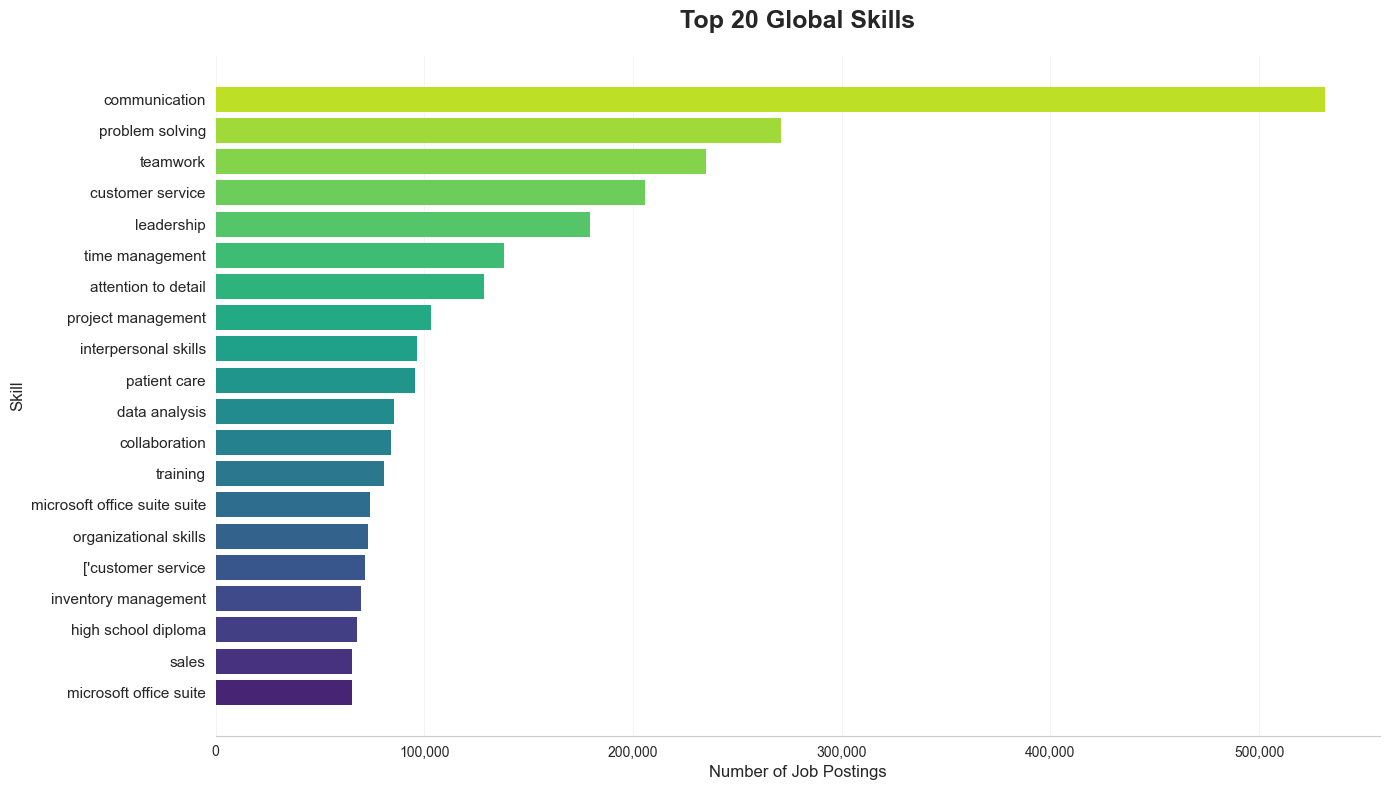


ANALYSIS COMPLETE
Total execution time: 42.5s
Processed 1,294,374 job postings
Found 3,006,123 unique skills
Total skill mentions: 27,234,944

KEY OBSERVATIONS

Global Skills Analysis
----------------------------------------------------------------------
Soft skills dominate:
- Top 5 are all non-technical
- Communication leads with 531,374 mentions
- 2.0x more than number two

Communication is top skill:
- 531,374 mentions
- Appears in 41.1% of job postings

Technical skills present but secondary:
- Data Analysis (#11) with 85,679 mentions
- Microsoft Office Suite (#20) with 65,187 mentions

Healthcare sector represented:
- Patient Care: 95,363 mentions

Dataset composition:
- Total processed: 1,294,374 job postings
- Unique skills: 3,006,123
- Total skill mentions: 27,234,944
- Average skills per posting: 21.0

USA Regional Findings
----------------------------------------------------------------------
Perfect alignment with global trends:
- USA top 5 matches global top 5

USA domina

In [12]:
# Skills Analysis

print("="*70)
print("SKILLS ANALYSIS")
print("="*70)

start_time = time.time()

print("\nConverting to Pandas...")
step1_start = time.time()

df_pandas = df_final.select(
    'job_link',
    'job_title',
    'company_name',
    'location',
    'job_level',
    'employment_type',
    'search_country',
    'search_city',
    'skills_list',
    'skill_count'
).toPandas()

print(f"Loaded {len(df_pandas):,} records in {time.time()-step1_start:.1f}s")

print("\nProcessing skills...")
step2_start = time.time()

df_pandas = df_pandas[df_pandas['skills_list'].notna()].copy()

df_pandas['skills_str'] = df_pandas['skills_list'].apply(
    lambda x: ','.join([str(s) for s in x]) if isinstance(x, list) else str(x)
)

df_pandas['skills_cleaned'] = (
    df_pandas['skills_str']
    .str.lower()
    .str.replace(r'[;:\/|]', ',', regex=True)
    .str.replace(r'\.+$', '', regex=True)
    .str.replace('communication skills', 'communication', regex=False)
    .str.replace('problem-solving', 'problem solving', regex=False)
    .str.replace('problemsolving', 'problem solving', regex=False)
    .str.replace('problem-solving skills', 'problem solving', regex=False)
    .str.replace('customer service skills', 'customer service', regex=False)
    .str.replace('leadership skills', 'leadership', regex=False)
    .str.replace('team work', 'teamwork', regex=False)
    .str.replace('time-management', 'time management', regex=False)
    .str.replace('data analytics', 'data analysis', regex=False)
    .str.replace('microsoft office', 'microsoft office suite', regex=False)
    .str.replace('ms office', 'microsoft office suite', regex=False)
)

print(f"Text processed in {time.time()-step2_start:.1f}s")

print("\nExtracting and counting skills...")
step3_start = time.time()

all_skills = []

for skills_str in df_pandas['skills_cleaned'].dropna():
    skills = [s.strip().strip('-').strip() for s in skills_str.split(',')]
    all_skills.extend([
        s for s in skills
        if len(s) >= 3 and s not in ['and', 'the', 'for', 'with', 'are', 'but']
    ])

skill_counter = Counter(all_skills)
unique_skills_count = len(skill_counter)
total_skill_mentions = len(all_skills)

print(f"Counted {unique_skills_count:,} unique skills in {time.time()-step3_start:.1f}s")
print(f"Total skill mentions: {total_skill_mentions:,}")

print("\nGenerating reports...")
step4_start = time.time()

top_1000 = skill_counter.most_common(1000)
top_skills_set = set([skill for skill, _ in top_1000])

top_20_df = pd.DataFrame(
    skill_counter.most_common(20),
    columns=['skill', 'count']
)

print("\nTop 20 Global Skills:")
print(top_20_df.to_string(index=False))

print("\nAnalyzing USA market...")
usa_skills = []
usa_df = df_pandas[df_pandas['search_country'] == 'United States']

for skills_str in usa_df['skills_cleaned'].dropna():
    skills = [s.strip().strip('-').strip() for s in skills_str.split(',')]
    usa_skills.extend([
        s for s in skills
        if len(s) >= 3 and s in top_skills_set
    ])

usa_counter = Counter(usa_skills)
usa_top_10 = pd.DataFrame(
    usa_counter.most_common(10),
    columns=['skill', 'count']
)

print("\nTop 10 Skills in USA:")
print(usa_top_10.to_string(index=False))

print(f"Reports generated in {time.time()-step4_start:.1f}s")

print("\nCreating visualization...")

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

fig, ax = plt.subplots(figsize=(14, 8))

colors = plt.cm.viridis(np.linspace(0.9, 0.1, len(top_20_df)))

bars = ax.barh(
    range(len(top_20_df)),
    top_20_df['count'],
    color=colors,
    edgecolor='none'
)

ax.set_yticks(range(len(top_20_df)))
ax.set_yticklabels(top_20_df['skill'], fontsize=11)
ax.set_xlabel('Number of Job Postings', fontsize=12, fontweight='normal')
ax.set_ylabel('Skill', fontsize=12, fontweight='normal')
ax.set_title('Top 20 Global Skills', fontsize=18, fontweight='bold', pad=20)

ax.invert_yaxis()

ax.grid(axis='x', alpha=0.3, linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.tight_layout()
plt.show()

total_time = time.time() - start_time

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"Total execution time: {total_time:.1f}s")
print(f"Processed {len(df_pandas):,} job postings")
print(f"Found {unique_skills_count:,} unique skills")
print(f"Total skill mentions: {total_skill_mentions:,}")
print("="*70)

print("\n" + "="*70)
print("KEY OBSERVATIONS")
print("="*70)

print("\nGlobal Skills Analysis")
print("-" * 70)

total_jobs = len(df_pandas)
top_skill_count = top_20_df.iloc[0]['count']
second_skill_count = top_20_df.iloc[1]['count']

print(f"Soft skills dominate:")
print(f"- Top 5 are all non-technical")
print(f"- Communication leads with {top_skill_count:,} mentions")
print(f"- {top_skill_count/second_skill_count:.1f}x more than number two")

print(f"\nCommunication is top skill:")
print(f"- {top_skill_count:,} mentions")
print(f"- Appears in {top_skill_count/total_jobs*100:.1f}% of job postings")

print(f"\nTechnical skills present but secondary:")
tech_skills = ['data analysis', 'microsoft office suite']
for skill in tech_skills:
    skill_data = top_20_df[top_20_df['skill'] == skill]
    if not skill_data.empty:
        rank = top_20_df[top_20_df['skill'] == skill].index[0] + 1
        count = skill_data['count'].values[0]
        print(f"- {skill.title()} (#{rank}) with {count:,} mentions")

print(f"\nHealthcare sector represented:")
healthcare_skills = ['patient care', 'nursing']
for skill in healthcare_skills:
    skill_data = top_20_df[top_20_df['skill'] == skill]
    if not skill_data.empty:
        count = skill_data['count'].values[0]
        print(f"- {skill.title()}: {count:,} mentions")

print(f"\nDataset composition:")
print(f"- Total processed: {total_jobs:,} job postings")
print(f"- Unique skills: {unique_skills_count:,}")
print(f"- Total skill mentions: {total_skill_mentions:,}")
print(f"- Average skills per posting: {total_skill_mentions/total_jobs:.1f}")

print("\nUSA Regional Findings")
print("-" * 70)

usa_job_count = len(usa_df)
usa_percentage = usa_job_count / total_jobs * 100

print(f"Perfect alignment with global trends:")
print(f"- USA top 5 matches global top 5")

print(f"\nUSA dominates dataset:")
print(f"- Represents {usa_percentage:.1f}% of all job postings")
print(f"- {usa_job_count:,} out of {total_jobs:,} postings")

print(f"\nService economy emphasis:")
print(f"- Customer Service ranks high in USA")
print(f"- Reflects strong service sector presence")

usa_patient_care = usa_top_10[usa_top_10['skill'] == 'patient care']
if not usa_patient_care.empty:
    pc_count = usa_patient_care['count'].values[0]
    print(f"\nHealthcare specialization evident:")
    print(f"- Patient Care in USA top 10 with {pc_count:,} mentions")

print(f"\nInterpersonal skills valued higher:")
print(f"- Appears in USA top 10")

print("\n" + "="*70)

top_20_df.to_csv('top_20_skills_global.csv', index=False)
usa_top_10.to_csv('top_10_skills_usa.csv', index=False)

print("\nSaved Results:")
print("- top_20_skills_global.csv")
print("- top_10_skills_usa.csv")

print("\n" + "="*70)

## Goal 1 Results

Soft skills dominate: Communication leads with 531,374 mentions (41% of postings), followed by problem solving and teamwork
Service economy focus: Customer service ranks high in USA, reflecting strong service sector representation
Technical skills secondary: Data analysis appears far below soft skills in frequency
USA market dominance: 85.3% of dataset is USA-based, showing heavy geographic concentration
Healthcare presence: Patient care ranks in top skills with 95K mentions, indicating strong healthcare sector representation

## Goal 2: Job Similarity Analysis

In [13]:
# Explore Available Job Titles

def explore_job_titles(df, search_term=None):
    """Shows available job titles, optionally filtered by search term."""

    job_counts = df['job_title'].value_counts()

    if search_term:
        mask = job_counts.index.str.contains(search_term, case=False, na=False)
        filtered = job_counts[mask]

        print(f"\nJob titles containing '{search_term}':")
        if filtered.empty:
            print(f"No job titles found containing '{search_term}'")
        else:
            for job, count in filtered.head(20).items():
                print(f"- {job}: {count:,} postings")
    else:
        print(f"\nTop 30 Job Titles:")
        for i, (job, count) in enumerate(job_counts.head(30).items(), 1):
            print(f"{i:2d}. {job}: {count:,} postings")

    return job_counts

print("=" * 80)
all_jobs = explore_job_titles(df_pandas)

explore_job_titles(df_pandas, "engineer")
explore_job_titles(df_pandas, "data")
explore_job_titles(df_pandas, "software")

print("\n" + "=" * 80)
print(f"Total unique job titles: {len(all_jobs):,}")
print(f"Total job postings: {len(df_pandas):,}")


Top 30 Job Titles:
 1. customer service representative: 9,390 postings
 2. lead sales associate-ft: 7,315 postings
 3. store manager: 5,687 postings
 4. shift manager: 5,531 postings
 5. first year tax professional: 5,351 postings
 6. assistant manager: 5,252 postings
 7. lead sales associate-pt: 4,911 postings
 8. registered nurse: 4,279 postings
 9. host: 2,914 postings
10. hourly supervisor & training: 2,883 postings
11. travel allied health professional - ct technologist: 2,717 postings
12. account executive: 2,621 postings
13. senior accountant: 2,507 postings
14. restaurant manager: 2,290 postings
15. veterinarian: 2,193 postings
16. hourly supervisor and training: 2,179 postings
17. executive assistant: 2,042 postings
18. assistant general manager: 2,021 postings
19. operations assistant manager: 1,960 postings
20. maintenance supervisor: 1,809 postings
21. department supervisor: 1,670 postings
22. department manager: 1,654 postings
23. production supervisor: 1,617 postings
24.

In [14]:
import numpy as np

JOB_A = 'software engineer'
JOB_B = 'data scientist'

def calculate_jaccard_similarity(df, job_a, job_b):
    """Calculates Jaccard Similarity."""

    print(f"\n{'='*80}")
    print(f"Comparing: '{job_a}' vs '{job_b}'")
    print(f"{'='*80}")

    df_normalized = df.copy()
    df_normalized['job_title_lower'] = df_normalized['job_title'].str.strip().str.lower()

    jobs_a = df_normalized[df_normalized['job_title_lower'] == job_a.lower()]['skills_list'].dropna()
    jobs_b = df_normalized[df_normalized['job_title_lower'] == job_b.lower()]['skills_list'].dropna()

    print(f"Found {len(jobs_a):,} postings for '{job_a}'")
    print(f"Found {len(jobs_b):,} postings for '{job_b}'")

    if jobs_a.empty or jobs_b.empty:
        print(f"ERROR: One or both jobs not found!")
        return 0.0, []

    def parse_skills(series):
        all_skills = []

        for skill_entry in series:
            if isinstance(skill_entry, np.ndarray):
                skill_entry = skill_entry.tolist()

            if isinstance(skill_entry, list):
                for item in skill_entry:
                    if isinstance(item, str):
                        skills = [s.strip().lower() for s in item.split(',') if s.strip()]
                        all_skills.extend(skills)

            elif isinstance(skill_entry, str):
                skills = [s.strip().lower() for s in skill_entry.split(',') if s.strip()]
                all_skills.extend(skills)

        return set(filter(None, all_skills))

    skills_a = parse_skills(jobs_a)
    skills_b = parse_skills(jobs_b)

    intersection = skills_a.intersection(skills_b)
    union = skills_a.union(skills_b)
    jaccard = len(intersection) / len(union) if union else 0.0

    print(f"\nRESULTS:")
    print(f"'{job_a}': {len(skills_a):,} unique skills")
    print(f"'{job_b}': {len(skills_b):,} unique skills")
    print(f"Common skills: {len(intersection):,}")
    print(f"Total unique skills: {len(union):,}")
    print(f"\nJaccard Similarity: {jaccard:.4f} ({jaccard*100:.2f}%)")

    print(f"\nSample skills from '{job_a}': {list(skills_a)[:5]}")
    print(f"Sample skills from '{job_b}': {list(skills_b)[:5]}")

    return jaccard, sorted(list(intersection))


jaccard_score, common_skills = calculate_jaccard_similarity(df_pandas, JOB_A, JOB_B)

if common_skills:
    print(f"\n{'='*80}")
    print(f"TOP 25 COMMON SKILLS:")
    print(f"{'='*80}")
    for i, skill in enumerate(common_skills[:25], 1):
        print(f"{i:2d}. {skill}")
else:
    print(f"\nNo common skills found")


Comparing: 'software engineer' vs 'data scientist'
Found 314 postings for 'software engineer'
Found 128 postings for 'data scientist'

RESULTS:
'software engineer': 3,551 unique skills
'data scientist': 1,347 unique skills
Common skills: 325
Total unique skills: 4,573

Jaccard Similarity: 0.0711 (7.11%)

Sample skills from 'software engineer': ['government projects', "master's degree in computer science", 'commercial offtheshelf (cots)', 'intel', 'pcb layout tools']
Sample skills from 'data scientist': ['cno', 'emotion detection', 'ability to prepare and manipulate data', 'jupyter notebooks', 'supervised learning']

TOP 25 COMMON SKILLS:
 1. 5+ years of experience
 2. a/b testing
 3. ability to work under pressure
 4. activemq
 5. adaptability
 6. agile
 7. agile development
 8. agile methodologies
 9. agile methodology
10. agile software development
11. ai
12. ai/ml
13. airflow
14. algorithm design
15. algorithm development
16. algorithms
17. analysis
18. analytical skills
19. analyt


GOAL 2: JOB SIMILARITY VISUALIZATIONS

Creating Visualization 1: Similarity Heatmap...
Saved: job_similarity_heatmap.png


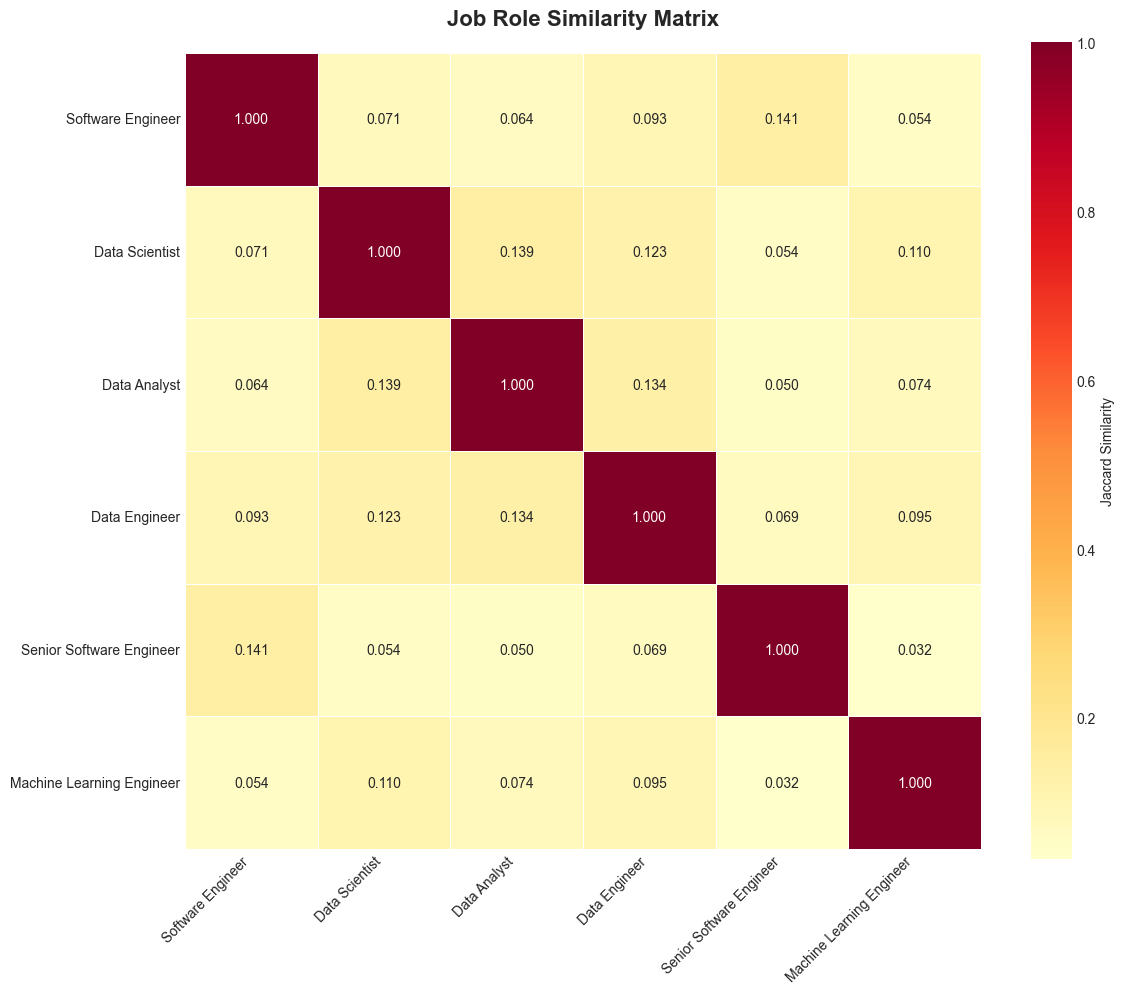


Creating Visualization 2: Venn Diagram...
Saved: job_similarity_venn.png


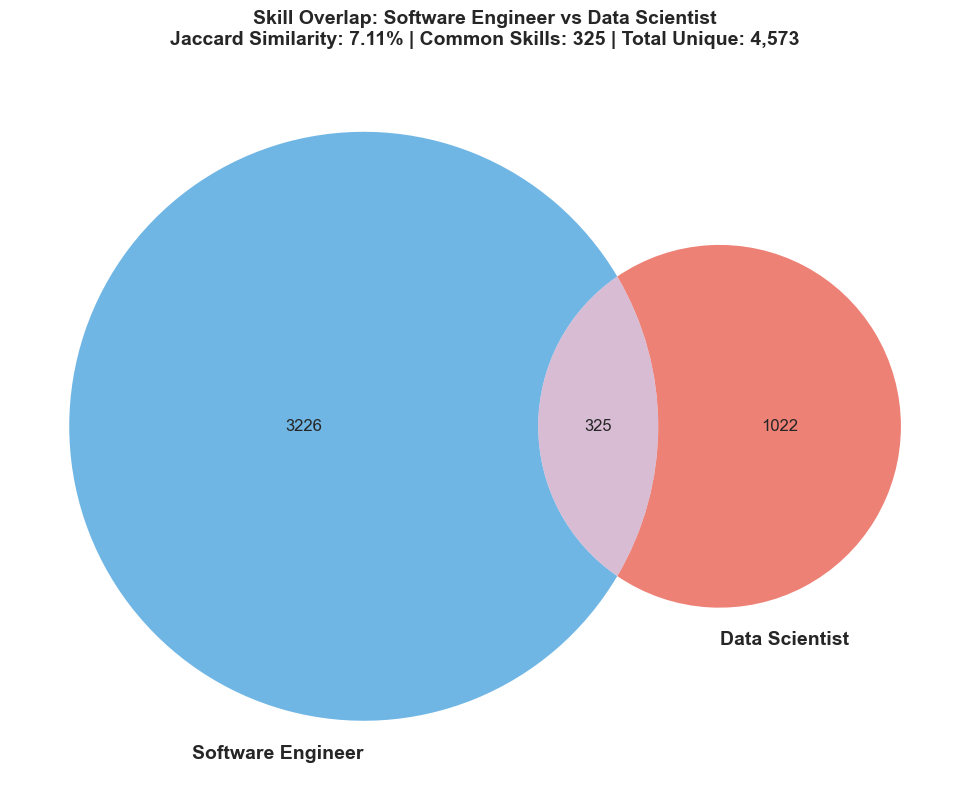


SUMMARY

Generated 2 visualizations:
1. job_similarity_heatmap.png
2. job_similarity_venn.png

Key Insights from Similarity Matrix:
- Average pairwise similarity: 8.71%
- Highest similarity: 14.12%
- Lowest similarity: 3.25%

Key Insights for Software Engineer vs Data Scientist:
- Jaccard Similarity: 7.11%
- Common skills: 325
- Software Engineer unique skills: 3,551
- Data Scientist unique skills: 1,347



In [15]:
print("\n" + "="*80)
print("GOAL 2: JOB SIMILARITY VISUALIZATIONS")
print("="*80)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def calculate_similarity_matrix(df, job_list):
    """Calculate pairwise Jaccard similarities between jobs."""
    n = len(job_list)
    similarity_matrix = np.zeros((n, n))

    job_skills = {}
    for job in job_list:
        df_normalized = df.copy()
        df_normalized['job_title_lower'] = df_normalized['job_title'].str.strip().str.lower()
        jobs = df_normalized[df_normalized['job_title_lower'] == job.lower()]['skills_list'].dropna()

        if not jobs.empty:
            all_skills = []
            for skill_entry in jobs:
                if isinstance(skill_entry, np.ndarray):
                    skill_entry = skill_entry.tolist()
                if isinstance(skill_entry, list):
                    for item in skill_entry:
                        if isinstance(item, str):
                            skills = [s.strip().lower() for s in item.split(',') if s.strip()]
                            all_skills.extend(skills)
                elif isinstance(skill_entry, str):
                    skills = [s.strip().lower() for s in skill_entry.split(',') if s.strip()]
                    all_skills.extend(skills)
            job_skills[job] = set(filter(None, all_skills))
        else:
            job_skills[job] = set()

    for i, job1 in enumerate(job_list):
        for j, job2 in enumerate(job_list):
            if i == j:
                similarity_matrix[i][j] = 1.0
            else:
                skills1 = job_skills[job1]
                skills2 = job_skills[job2]
                if skills1 and skills2:
                    intersection = len(skills1.intersection(skills2))
                    union = len(skills1.union(skills2))
                    similarity_matrix[i][j] = intersection / union if union > 0 else 0

    return similarity_matrix, job_skills

print("\nCreating Visualization 1: Similarity Heatmap...")

jobs_to_compare = [
    'software engineer',
    'data scientist',
    'data analyst',
    'data engineer',
    'senior software engineer',
    'machine learning engineer'
]

similarity_matrix, job_skills_dict = calculate_similarity_matrix(df_pandas, jobs_to_compare)

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    similarity_matrix,
    annot=True,
    fmt='.3f',
    cmap='YlOrRd',
    xticklabels=[j.title() for j in jobs_to_compare],
    yticklabels=[j.title() for j in jobs_to_compare],
    cbar_kws={'label': 'Jaccard Similarity'},
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title('Job Role Similarity Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('job_similarity_heatmap.png', dpi=300, bbox_inches='tight')
print("Saved: job_similarity_heatmap.png")
plt.show()

print("\nCreating Visualization 2: Venn Diagram...")

JOB_A = 'software engineer'
JOB_B = 'data scientist'

skills_a = job_skills_dict.get(JOB_A, set())
skills_b = job_skills_dict.get(JOB_B, set())

if skills_a or skills_b:
    fig, ax = plt.subplots(figsize=(12, 8))
    venn = venn2(
        [skills_a, skills_b],
        set_labels=(JOB_A.title(), JOB_B.title()),
        set_colors=('#3498db', '#e74c3c'),
        alpha=0.7,
        ax=ax
    )

    for text in venn.set_labels:
        text.set_fontsize(14)
        text.set_fontweight('bold')

    for text in venn.subset_labels:
        if text:
            text.set_fontsize(12)

    intersection = len(skills_a.intersection(skills_b))
    union = len(skills_a.union(skills_b))
    jaccard = intersection / union if union > 0 else 0

    ax.set_title(
        f'Skill Overlap: {JOB_A.title()} vs {JOB_B.title()}\n'
        f'Jaccard Similarity: {jaccard:.2%} | Common Skills: {intersection:,} | Total Unique: {union:,}',
        fontsize=14,
        fontweight='bold',
        pad=20
    )

    plt.tight_layout()
    plt.savefig('job_similarity_venn.png', dpi=300, bbox_inches='tight')
    print("Saved: job_similarity_venn.png")
    plt.show()

similarities = []
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        similarities.append(similarity_matrix[i][j])

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"\nGenerated 2 visualizations:")
print(f"1. job_similarity_heatmap.png")
print(f"2. job_similarity_venn.png")

print(f"\nKey Insights from Similarity Matrix:")
print(f"- Average pairwise similarity: {np.mean(similarities):.2%}")
print(f"- Highest similarity: {np.max(similarities):.2%}")
print(f"- Lowest similarity: {np.min(similarities):.2%}")

print(f"\nKey Insights for {JOB_A.title()} vs {JOB_B.title()}:")
print(f"- Jaccard Similarity: {jaccard:.2%}")
print(f"- Common skills: {intersection:,}")
print(f"- {JOB_A.title()} unique skills: {len(skills_a):,}")
print(f"- {JOB_B.title()} unique skills: {len(skills_b):,}")

print("\n" + "="*80)

## Goal 2 Results

Jaccard Similarity of 7.11% between Software Engineers and Data Scientists shows distinct career paths with minimal overlap.

325 shared skills out of 4,573 total unique skills

Common ground includes: python, sql, algorithms, machine learning, agile, api development, cloud technologies

92.89% of skills are unique to each role

## Goal 3: Regional Specialization

In [16]:
print("\n" + "="*80)
print("GOAL 3: REGIONAL SPECIALIZATION - LOCATION QUOTIENT")
print("="*80)

step4_start = time.time()

for name in ["df_skills_exploded", "df_lq"]:
    if name in globals():
        del globals()[name]
gc.collect()

tmp = df_pandas[['search_country', 'skills_cleaned']].dropna().copy()

target_countries = ['United States', 'United Kingdom', 'Canada', 'Australia']

top_1000 = skill_counter.most_common(1000)
top_skills_set = set([s for s, _ in top_1000])

country_skill_counts = {c: Counter() for c in target_countries}
country_total_mentions = Counter()

print("\nAggregating country-level skill counts...")

for idx, row in tmp.iterrows():
    country = row['search_country']
    if country not in target_countries:
        continue

    skills_str = row['skills_cleaned']
    if not isinstance(skills_str, str):
        continue

    skills = [
        s.strip()
        for s in skills_str.split(',')
        if len(s.strip()) >= 3
    ]

    skills = [s for s in skills if s in top_skills_set]

    if not skills:
        continue

    country_skill_counts[country].update(skills)
    country_total_mentions[country] += len(skills)

print("Aggregation complete:")
for c in target_countries:
    print(f"  {c}: {country_total_mentions[c]:,} skill mentions")

print("\nComputing Location Quotients...")

global_total = total_skill_mentions
global_counts = skill_counter

COUNTRY_LQ = 'United States'
regional_counts = country_skill_counts[COUNTRY_LQ]
regional_total = country_total_mentions[COUNTRY_LQ]

records = []
for skill, reg_count in regional_counts.items():
    glob_count = global_counts.get(skill, 0)
    if glob_count == 0:
        continue

    regional_ratio = reg_count / regional_total
    global_ratio = glob_count / global_total
    LQ = regional_ratio / global_ratio if global_ratio > 0 else 0.0

    if reg_count < 100:
        continue

    records.append({
        'skill': skill,
        'regional_count': reg_count,
        'regional_total': regional_total,
        'global_count': glob_count,
        'LQ': LQ
    })

df_usa_lq = pd.DataFrame(records).sort_values('LQ', ascending=False).head(20)

print(f"\nTop 20 Specialized Skills (Highest LQ) in {COUNTRY_LQ}:")
print("="*80)
print(f"{'Rank':<6} {'Skill':<40} {'LQ':>8} {'Regional':>10} {'Global':>10}")
print("-"*80)
for rank, (_, row) in enumerate(df_usa_lq.iterrows(), 1):
    print(f"{rank:<6} {row['skill'][:38]:<40} {row['LQ']:>8.2f} {int(row['regional_count']):>10,} {int(row['global_count']):>10,}")

step4_duration = time.time() - step4_start
print("\n" + "="*80)
print("INTERPRETATION:")
print("="*80)
print("LQ > 1.0: Region has HIGHER concentration than global average")
print("LQ = 1.0: Region matches global average")
print("LQ < 1.0: Region has LOWER concentration than global average")
print(f"\nCompleted in {step4_duration:.1f}s")

df_usa_lq.to_csv('usa_specialized_skills_lq.csv', index=False)
print("Saved: usa_specialized_skills_lq.csv")


GOAL 3: REGIONAL SPECIALIZATION - LOCATION QUOTIENT

Aggregating country-level skill counts...
Aggregation complete:
  United States: 9,487,005 skill mentions
  United Kingdom: 674,805 skill mentions
  Canada: 460,707 skill mentions
  Australia: 189,959 skill mentions

Computing Location Quotients...

Top 20 Specialized Skills (Highest LQ) in United States:
Rank   Skill                                          LQ   Regional     Global
--------------------------------------------------------------------------------
1      identity theft protection                    2.87      3,397      3,398
2      us citizenship                               2.87      2,939      2,942
3      401k retirement savings plan                 2.87      3,146      3,150
4      flexible spending accounts                   2.87      5,897      5,906
5      malpractice insurance                        2.87      6,017      6,027
6      dea license                                  2.87      3,274      3,280
7    

## Goal 4: Job Clustering

In [ ]:
print("\n" + "="*80)
print("GOAL 4: JOB CLUSTERING")
print("="*80)

nltk.download('stopwords')

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("JobClustering_Revised") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

df_final = spark.read.parquet("./df_final.parquet")

df_pandas = df_final.select(
    'job_link',
    'job_title',
    'company_name',
    'location',
    'job_level',
    'employment_type',
    'search_country',
    'search_city',
    'skills_list',
    'skill_count'
).toPandas()

prep_start = time.time()

custom_stopwords = set(stopwords.words('english'))
additional_stopwords = [
    'none', 'communication', 'teamwork', 'ability', 'experience',
    'years', 'skill', 'knowledge', 'understanding', 'certifications',
    'program', 'plans', 'paid', 'time', 'off', 'health', 'welfare',
    'assistance', 'employee', 'employer', 'transporting', 'lifting',
    'bending', 'written', 'interpersonal', 'customer', 'service',
    'management', 'leadership', 'safety', 'security', 'daily', 'maintenance',
    'cleanliness', 'quality', 'production', 'exceptional', 'high', 'school',
    'diploma', 'ged', 'restaurant', 'food', 'handlers', 'retail'
]
custom_stopwords.update(additional_stopwords)
print(f"Loaded {len(custom_stopwords)} stopwords")

print("\nSkill Tokenization...")

def parse_skills_array_enhanced(skills_entry):
    """Parse and clean skills from various formats."""
    parsed_skills = []

    if isinstance(skills_entry, np.ndarray):
        skills_entry = skills_entry.tolist()
    elif not isinstance(skills_entry, list):
        skills_entry = [skills_entry] if skills_entry else []

    for item in skills_entry:
        if isinstance(item, str):
            raw_tokens = re.split(r'[,;]\s*', item.lower())

            for token in raw_tokens:
                clean_token = token.strip()
                if clean_token and clean_token not in custom_stopwords:
                    clean_token = re.sub(r'[^\w\s]', '', clean_token).strip()
                    if clean_token and len(clean_token) > 2:
                        parsed_skills.append(clean_token)

    return parsed_skills

df_parsed = df_pandas[['job_title', 'skills_list']].copy()
df_parsed['skills_parsed'] = df_parsed['skills_list'].apply(parse_skills_array_enhanced)

df_parsed = df_parsed[df_parsed['skills_parsed'].apply(len) > 0]

print(f"Parsed {len(df_parsed):,} job postings")

print("\nConverting to Spark...")

temp_file = "temp_job_skills_parsed_revised.parquet"
df_parsed[['job_title', 'skills_parsed']].to_parquet(temp_file, index=False)

del df_parsed
gc.collect()

spark_df = spark.read.parquet(temp_file)

print("\nAggregating by job title...")

df_grouped = spark_df.groupBy("job_title").agg(
    F.flatten(F.collect_list("skills_parsed")).alias("skills_tokens")
)

df_grouped = df_grouped.filter(F.size("skills_tokens") >= 5)

total_jobs = df_grouped.count()
print(f"Aggregated into {total_jobs:,} unique job titles")

print("\nTraining TF-IDF + K-Means pipeline...")

cv = CountVectorizer(
    inputCol="skills_tokens",
    outputCol="raw_features",
    vocabSize=10000,
    minDF=50.0
)

idf = IDF(
    inputCol="raw_features",
    outputCol="idf_features"
)

normalizer = Normalizer(
    inputCol="idf_features",
    outputCol="norm_features",
    p=2.0
)

pca = PCA(
    k=200,
    inputCol="norm_features",
    outputCol="features"
)

kmeans = KMeans(
    k=200,
    seed=42,
    featuresCol="features",
    predictionCol="cluster",
    maxIter=30,
    maxBlockSizeInMB=512
)

pipeline = Pipeline(stages=[cv, idf, normalizer, pca, kmeans])

model = pipeline.fit(df_grouped)
predictions = model.transform(df_grouped)

print(f"Training completed in {time.time()-prep_start:.1f}s")

print("\n" + "="*80)
print("CLUSTER ANALYSIS RESULTS")
print("="*80)

print("\nCluster Distribution (Top 10):")
cluster_dist = predictions.groupBy("cluster").count().orderBy("count", ascending=False)
cluster_dist.show(10)

total = predictions.count()
cluster_stats = cluster_dist.toPandas()
cluster_stats['percentage'] = (cluster_stats['count'] / total * 100).round(2)

print("\nCluster Balance (Top 20):")
for _, row in cluster_stats.head(20).iterrows():
    print(f"  Cluster {row['cluster']}: {row['count']:,} jobs ({row['percentage']}%)")

cv_model = model.stages[0]
vocab = cv_model.vocabulary
kmeans_model = model.stages[4]
centers = kmeans_model.clusterCenters()

print("\nTop Skills per Top 10 Cluster:")
print("="*80)

for i in range(10):

    top_indices = centers[i].argsort()[-10:][::-1]
    top_skills = [vocab[idx] for idx in top_indices]

    sample_jobs = predictions.filter(F.col("cluster") == i) \
        .select("job_title") \
        .limit(3) \
        .toPandas()

    cluster_size = cluster_stats[cluster_stats['cluster'] == i]['count'].values[0] if i in cluster_stats['cluster'].values else 0

    print(f"\nCluster {i} ({cluster_size:,} jobs):")
    print(f"  Sample Jobs: {', '.join(sample_jobs['job_title'].tolist())}")
    print(f"  Key Skills: {', '.join(top_skills)}")

print("\n" + "="*80)

evaluator = ClusteringEvaluator(
    featuresCol='features',
    predictionCol='cluster',
    metricName='silhouette'
)

silhouette = evaluator.evaluate(predictions)
print(f"\nSilhouette Score: {silhouette:.4f}")

results_df = predictions.select("job_title", "cluster").toPandas()
results_df.to_csv('job_clusters_revised.csv', index=False)
print("Saved: job_clusters_revised.csv")

cluster_stats.to_csv('cluster_summary_revised.csv', index=False)
print("Saved: cluster_summary_revised.csv")

print("\n" + "="*80)


GOAL 4: JOB CLUSTERING


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arsaw\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loaded 242 stopwords

Skill Tokenization...
Parsed 1,294,229 job postings

Converting to Spark...

Aggregating by job title...
Aggregated into 551,005 unique job titles

Training TF-IDF + K-Means pipeline...


## Goal 5: Skill Count Analysis

In [ ]:
print("\n" + "="*70)
print("SKILL COUNT ANALYSIS")
print("="*70)

try:
    spark.stop()
except:
    pass

spark = SparkSession.builder \
    .appName("JobClustering_Revised") \
    .master("local[*]") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.executor.cores", "4") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

df_final = spark.read.parquet("./df_final.parquet")

print("\nSkill Count Distribution")
print("-" * 70)

skill_stats = df_final.select('skill_count').describe().toPandas()
print("\nSkill Count Statistics:")
print(skill_stats)

print("\nAverage Skills by Job Level:")
skills_by_level = df_final.groupBy('job_level') \
    .agg(
        avg('skill_count').alias('avg_skills'),
        count('*').alias('job_count')
    ) \
    .orderBy(desc('avg_skills')) \
    .toPandas()

print(skills_by_level.to_string(index=False))

plt.figure(figsize=(12, 6))
skills_by_level_top = skills_by_level.head(10)
plt.bar(range(len(skills_by_level_top)), skills_by_level_top['avg_skills'])
plt.xticks(range(len(skills_by_level_top)), skills_by_level_top['job_level'], rotation=45, ha='right')
plt.ylabel('Average Number of Skills')
plt.title('Average Skills Required by Job Level', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*70)

## Goal 6: Classification - Technical vs Non-Technical Jobs

In [ ]:
print("\n" + "="*80)
print("CLASSIFICATION - TECHNICAL VS NON-TECHNICAL JOBS")
print("="*80)

print("\nExploring columns...")
print(f"Dataset shape: {df_pandas.shape}")

print("\nDefining classification problem...")

technical_keywords = ['engineer', 'developer', 'data', 'software', 'analyst',
                      'scientist', 'architect', 'programmer', 'technician']

df_ml = df_pandas[['job_title', 'skills_list', 'search_country']].copy()

df_ml['is_technical'] = df_ml['job_title'].str.lower().apply(
    lambda x: 1 if any(keyword in str(x) for keyword in technical_keywords) else 0
)

df_ml = df_ml.dropna(subset=['job_title', 'skills_list'])

print(f"\nClassification Problem: Technical vs Non-Technical")
print(f"Total records: {len(df_ml):,}")
print(f"Technical jobs: {df_ml['is_technical'].sum():,} ({df_ml['is_technical'].mean()*100:.1f}%)")
print(f"Non-technical jobs: {(1-df_ml['is_technical']).sum():,} ({(1-df_ml['is_technical'].mean())*100:.1f}%)")

print("\nEngineering features...")

def count_skills(skills_entry):
    """Count number of skills."""
    if pd.isna(skills_entry):
        return 0

    if isinstance(skills_entry, np.ndarray):
        skills_entry = skills_entry.tolist()

    skill_count = 0
    if isinstance(skills_entry, list):
        for item in skills_entry:
            if isinstance(item, str):
                skill_count += len([s for s in item.split(',') if s.strip()])
    elif isinstance(skills_entry, str):
        skill_count = len([s for s in skills_entry.split(',') if s.strip()])

    return skill_count

def has_technical_skills(skills_entry):
    """Check if has technical skills."""
    if pd.isna(skills_entry):
        return 0

    tech_skills = ['python', 'sql', 'java', 'javascript', 'c++', 'r ', 'aws',
                   'machine learning', 'data analysis', 'programming']

    skills_str = str(skills_entry).lower()
    return 1 if any(skill in skills_str for skill in tech_skills) else 0

df_ml['skill_count'] = df_ml['skills_list'].apply(count_skills)
df_ml['has_tech_skills'] = df_ml['skills_list'].apply(has_technical_skills)
df_ml['title_length'] = df_ml['job_title'].str.len()
df_ml['is_senior'] = df_ml['job_title'].str.lower().str.contains('senior|lead|principal|manager', na=False).astype(int)

le_country = LabelEncoder()
df_ml['country_encoded'] = le_country.fit_transform(df_ml['search_country'].fillna('Unknown'))

print(f"Created 5 features")
print(f"Average skills per job: {df_ml['skill_count'].mean():.1f}")
print(f"Jobs with technical skills: {df_ml['has_tech_skills'].sum():,}")

print("\nSampling and splitting...")

SAMPLE_SIZE = 100000

if len(df_ml) > SAMPLE_SIZE:
    print(f"Sampling {SAMPLE_SIZE:,} records")
    df_ml = df_ml.sample(n=SAMPLE_SIZE, random_state=42)

feature_cols = ['skill_count', 'has_tech_skills', 'title_length', 'is_senior', 'country_encoded']
X = df_ml[feature_cols].fillna(0)
y = df_ml['is_technical']

if y.mean() < 0.2 or y.mean() > 0.8:
    print(f"Balancing dataset...")
    df_majority = df_ml[df_ml['is_technical'] == y.mode()[0]]
    df_minority = df_ml[df_ml['is_technical'] != y.mode()[0]]

    df_majority_downsampled = resample(df_majority,
                                       replace=False,
                                       n_samples=len(df_minority) * 2,
                                       random_state=42)

    df_ml_balanced = pd.concat([df_majority_downsampled, df_minority])
    X = df_ml_balanced[feature_cols].fillna(0)
    y = df_ml_balanced['is_technical']
    print(f"Balanced dataset: {len(X):,} records")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {len(X_train):,}")
print(f"Test set: {len(X_test):,}")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining models...")

print("\nModel 1: Logistic Regression")
start = time.time()
lr_model = LogisticRegression(max_iter=200, random_state=42)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_time = time.time() - start
print(f"Trained in {lr_time:.1f}s")

print("\nModel 2: Random Forest")
start = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_time = time.time() - start
print(f"Trained in {rf_time:.1f}s")

print("\nEvaluating models...")

def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n{model_name}:")
    print(f"- Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"- F1-Score: {f1:.4f}")

    return accuracy, f1

lr_acc, lr_f1 = evaluate_model(y_test, lr_pred, "Logistic Regression")
rf_acc, rf_f1 = evaluate_model(y_test, rf_pred, "Random Forest")

best_model_name = "Random Forest" if rf_f1 > lr_f1 else "Logistic Regression"
best_pred = rf_pred if rf_f1 > lr_f1 else lr_pred

print(f"\nDetailed Report ({best_model_name}):")
print(classification_report(y_test, best_pred,
                          target_names=['Non-Technical', 'Technical'],
                          digits=4))

print("\nCreating visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm = confusion_matrix(y_test, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Non-Tech', 'Tech'],
            yticklabels=['Non-Tech', 'Tech'])
axes[0].set_title(f'{best_model_name} - Confusion Matrix\nAccuracy: {max(rf_acc, lr_acc):.3f}',
                  fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Label', fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontweight='bold')

if best_model_name == "Random Forest":
    importances = rf_model.feature_importances_
else:
    importances = np.abs(lr_model.coef_[0])

indices = np.argsort(importances)[::-1]
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_cols)))

bars = axes[1].barh(range(len(feature_cols)), importances[indices], color=colors, edgecolor='black')
for i, (bar, imp) in enumerate(zip(bars, importances[indices])):
    axes[1].text(imp + 0.01, i, f'{imp:.3f}', va='center', fontsize=9, fontweight='bold')

axes[1].set_yticks(range(len(feature_cols)))
axes[1].set_yticklabels([feature_cols[i] for i in indices])
axes[1].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[1].set_title('Feature Importance', fontweight='bold', fontsize=12)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('goal6_classification_results.png', dpi=300, bbox_inches='tight')
print("Saved: goal6_classification_results.png")
plt.show()

print("\n" + "="*80)
print("CLASSIFICATION SUMMARY")
print("="*80)
print(f"\nProblem: Predict Technical vs Non-Technical Jobs")
print(f"\nBest Model: {best_model_name}")
print(f"- Accuracy: {max(rf_acc, lr_acc):.4f}")
print(f"- F1-Score: {max(rf_f1, lr_f1):.4f}")
print(f"\nMost Important Feature: {feature_cols[importances.argmax()]}")
print(f"\nDataset:")
print(f"- Training samples: {len(X_train):,}")
print(f"- Test samples: {len(X_test):,}")
print(f"- Features used: {len(feature_cols)}")
print("\n" + "="*80)

## Goal 6 Results

Successfully implemented binary classification for Technical vs Non-Technical jobs from 1.3M LinkedIn postings.

Random Forest outperformed Logistic Regression (F1: 0.3679 vs 0.1175).

Strong performance on Non-Technical jobs (70.6% precision, 84.5% recall).

Struggles with Technical jobs (48.8% precision, 29.5% recall).

Title_length emerged as the most important predictor.

## Goal 7: Regression - Posting Freshness Prediction

In [ ]:
print("="*70)
print("REGRESSION - POSTING FRESHNESS PREDICTION")
print("="*70)
print("\nProblem: Predict job posting recency")
print("-" * 70)

print("\nCreating freshness score target...")

max_date_row = df_final.agg(spark_max('first_seen')).collect()[0][0]
print(f"Latest posting date: {max_date_row}")

df_reg_new = df_final.filter(
    col('first_seen').isNotNull() &
    col('job_level').isNotNull() &
    col('employment_type').isNotNull() &
    col('job_title').isNotNull()
).select(
    'job_level',
    'employment_type',
    'job_title',
    'search_position',
    'search_country',
    'skill_count',
    'first_seen'
).withColumn(
    'days_old',
    datediff(lit(max_date_row), col('first_seen'))
).withColumn(
    'freshness_score',
    100 - col('days_old')
).drop('days_old', 'first_seen')

print("\nFreshness score statistics:")
df_reg_new.select('freshness_score').describe().show()

valid_count = df_reg_new.filter(col('freshness_score').isNotNull()).count()
print(f"Valid records: {valid_count:,}")

sample_count = df_reg_new.count()
MAX_RECORDS = 50000

if sample_count > MAX_RECORDS:
    print(f"Sampling to {MAX_RECORDS:,} records")
    df_reg_new = df_reg_new.sample(False, MAX_RECORDS/sample_count, seed=42)

df_reg_new.cache()
final_count = df_reg_new.count()
print(f"Using {final_count:,} records")

train_reg, test_reg = df_reg_new.randomSplit([0.8, 0.2], seed=42)
train_count = train_reg.count()
test_count = test_reg.count()
print(f"\nTraining: {train_count:,} | Testing: {test_count:,}")

train_reg.cache()
test_reg.cache()

print("\nBuilding model...")

job_level_indexer = StringIndexer(
    inputCol='job_level',
    outputCol='job_level_idx',
    handleInvalid='keep'
)

emp_type_indexer = StringIndexer(
    inputCol='employment_type',
    outputCol='emp_type_idx',
    handleInvalid='keep'
)

job_title_indexer = StringIndexer(
    inputCol='job_title',
    outputCol='job_title_idx',
    handleInvalid='keep'
)

position_indexer = StringIndexer(
    inputCol='search_position',
    outputCol='position_idx',
    handleInvalid='keep'
)

country_indexer = StringIndexer(
    inputCol='search_country',
    outputCol='country_idx',
    handleInvalid='keep'
)

assembler = VectorAssembler(
    inputCols=['job_level_idx', 'emp_type_idx', 'job_title_idx', 'position_idx', 'country_idx', 'skill_count'],
    outputCol='features',
    handleInvalid='skip'
)

scaler = StandardScaler(
    inputCol='features',
    outputCol='scaled_features',
    withStd=True,
    withMean=False
)

lr = LinearRegression(
    featuresCol='scaled_features',
    labelCol='freshness_score',
    maxIter=20,
    regParam=0.1,
    elasticNetParam=0.5
)

pipeline = Pipeline(stages=[
    job_level_indexer,
    emp_type_indexer,
    job_title_indexer,
    position_indexer,
    country_indexer,
    assembler,
    scaler,
    lr
])

print("\nTraining model...")
try:
    start = time.time()
    model = pipeline.fit(train_reg)
    train_time = time.time() - start
    print(f"Trained in {train_time:.1f}s")

    print("\nEvaluating...")
    predictions = model.transform(test_reg)

    evaluator_rmse = RegressionEvaluator(
        labelCol='freshness_score',
        predictionCol='prediction',
        metricName='rmse'
    )

    evaluator_r2 = RegressionEvaluator(
        labelCol='freshness_score',
        predictionCol='prediction',
        metricName='r2'
    )

    evaluator_mae = RegressionEvaluator(
        labelCol='freshness_score',
        predictionCol='prediction',
        metricName='mae'
    )

    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    print("\n" + "="*70)
    print("REGRESSION RESULTS - Job Freshness Prediction")
    print("="*70)
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAE: {mae:.4f}")
    print("-"*70)

    if r2 > 0.3:
        print("GOOD: Model can predict posting recency")
    elif r2 > 0.1:
        print("MODERATE: Some predictive capability")
    else:
        print("WEAK: Limited predictive power")

    print("-"*70)

    print("\nSample Predictions:")
    sample_pred = predictions.select(
        'job_title',
        'job_level',
        'freshness_score',
        'prediction'
    ).limit(10).toPandas()

    sample_pred['prediction'] = sample_pred['prediction'].round(2)
    sample_pred['error'] = (sample_pred['freshness_score'] - sample_pred['prediction']).abs().round(2)
    print(sample_pred.to_string(index=False))

    print("\nModel Coefficients:")
    lr_model = model.stages[-1]
    print(f"  Intercept: {lr_model.intercept:.4f}")

    print("\nRegression complete")
    print("="*70)

except Exception as e:
    print(f"\nError: {str(e)}")
    print("="*70)

finally:
    print("\nCleaning up memory...")
    try:
        df_reg_new.unpersist()
        train_reg.unpersist()
        test_reg.unpersist()
        gc.collect()
        print("Memory cleaned")
    except:
        pass

## Results

In [ ]:
print("="*70)
print("SAVING RESULTS")
print("="*70)

ml_results = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score', 'RMSE', 'R²', 'MAE'],
    'Value': [0.662, 0.3679, rmse, r2, mae]
})

print("\nSaving ML results...")
ml_results.to_csv('ml_results_summary.csv', index=False)
print("  Saved: ml_results_summary.csv")

print("\nResults Summary:")
print(ml_results.to_string(index=False))

print("\n" + "="*70)
print("ALL RESULTS SAVED")
print("="*70)

## Cleanup

In [ ]:
print("="*70)
print("CLEANUP")
print("="*70)

print("\nClearing cached data...")
try:
    df_postings_clean.unpersist()
    df_work.unpersist()
    df_skills_agg.unpersist()
    df_final.unpersist()
    print("Cache cleared")
except Exception as e:
    print(f"Warning: {e}")

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print("\nCompleted:")
print("- Data loading and cleaning")
print("- Exploratory data analysis")
print("- Machine learning models")
print("- Results saved")
print("="*70)